# Projet GouvImmo, partie 3: Data viz

### Introduction:

Ce notebook à pour but d'effectuer un premier rapport de data visualisation, dans le cadre du projet fil rouge "GouvImmo" chez Datascientest. 

### Jeu de données:

Les données ont été préalablement importés, fusionnées puis triées dans les notebook nommés gouvimmo_project_part1 et gouvimmo_project_part2 et sauvegardés dans un fichier csv nommé IDF_2019_to_2021_v2.csv

Le dataframe comporte les données de ventes immobilières de la région Ile de France, de 2019 à 2021. Il comporte des variables relatives à la localisation du bien, au type de bien vendu, à sa valeur et à ses carractéristiques (surface, nombre de pièces, nombre de dépendances, ...). 

Une vente est appellée "mutation", et est identifiée par un numéro unique "id_mutation". Chaque mutation comporte au moins un "bien primaire", c'est à dire une maison, un appartement ou un terrain à bâtir. Une mutation peut également comporter un ou plusieurs biens secondaires, c'est à dire 1 à 2 "terrain autre" (aussi appelé "terrain secondaire") et / ou 1 à 2 dépendances.

# Importation des librairies et du fichier de données en csv:

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
pd.pandas.set_option('display.max_columns',None)
import warnings
warnings.filterwarnings('ignore')

In [5]:
# df=pd.read_csv("IDF_2019_to_2021_v2.csv")
# df.head()
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path = '/content/drive/MyDrive/05-Livrable/01-Étape_1  Audit des données + DataViz’ 28 04/Bases de données csv/IDF_2019_to_2021_v2.csv'
df = pd.read_csv(path)

Pour étudier plus facilement les données relatives aux biens construits (appartements et maisons), nous allons créer un dataframe ne contenant que les mutations correspondantes:

In [7]:
#Séparation en dataframes dédiés aux biens construis et aux terrains:
locaux=df[(df["Maison"]+df["Appartement"])!=0]

# Etude des outliers:

### Surface habitable et nombre de pièces:

Nous allons considérer qu'un bien construit doit nécessairement comporter au moins une pièce principale et une surface habitable minimale de 10m². Tous les biens ne correspondants pas à ces critères seront considérés comme outliers.

In [8]:
#Nombre de biens de type maison ou appartement avec un nombre de pièces à 0 ou une surface habitable inférieure à 10m²:
print("Nombre de biens avec une surface habitable de moins de 10 m²: ", len(locaux[locaux["surface_reelle_bati"]<10]))
print("Nombre de biens avec 0 pièces principales: ", len(locaux[locaux["nombre_pieces_principales"]==0]))

Nombre de biens avec une surface habitable de moins de 10 m²:  940
Nombre de biens avec 0 pièces principales:  176


Ces données sont aberrantes et devrons être retirées.

In [9]:
#Récupération de la liste des mutations concernées:
toremove1=locaux[locaux["surface_reelle_bati"]<10]["id_mutation"].unique()
toremove2=locaux[locaux["nombre_pieces_principales"]==0]["id_mutation"].unique()

#Retrait des mutations concernées dans le dataframe initial:
df=df.loc[df["id_mutation"].isin(toremove1)==False]
df=df.loc[df["id_mutation"].isin(toremove2)==False]

locaux=df[(df["Maison"]+df["Appartement"])!=0]

#Vérification:
print("Nombre de biens avec une surface indiqué à moins de 10 m²: ", len(locaux[locaux["surface_reelle_bati"]<10]))
print("Nombre de biens avec 0 pièces principales: ", len(locaux[locaux["nombre_pieces_principales"]==0]))

Nombre de biens avec une surface indiqué à moins de 10 m²:  0
Nombre de biens avec 0 pièces principales:  0


Nous allons maintenant afficher la distribution des variables nombre de pièces et surface habitable.

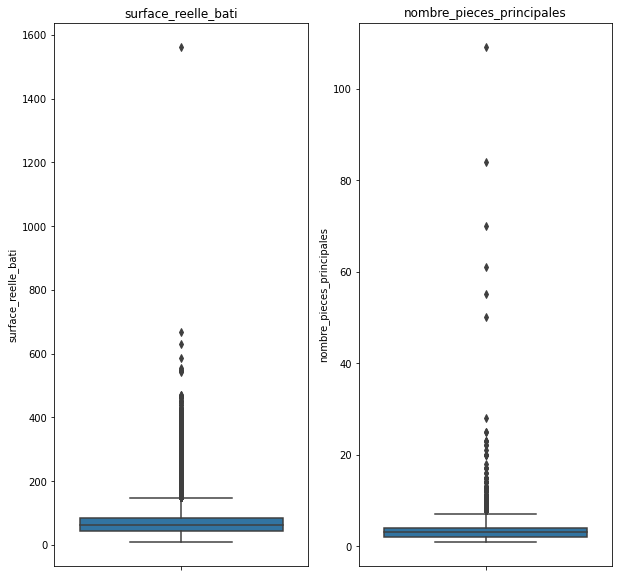

In [10]:
#Boite à moustaches surface batiment et nombre de pièces:
fig = plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
sns.boxplot(y=locaux["surface_reelle_bati"])
plt.title("surface_reelle_bati")

plt.subplot(1, 2, 2)
sns.boxplot(y=locaux["nombre_pieces_principales"])
plt.title("nombre_pieces_principales");

On constate beaucoups de valeurs extrèmes dans les valeurs hautes.

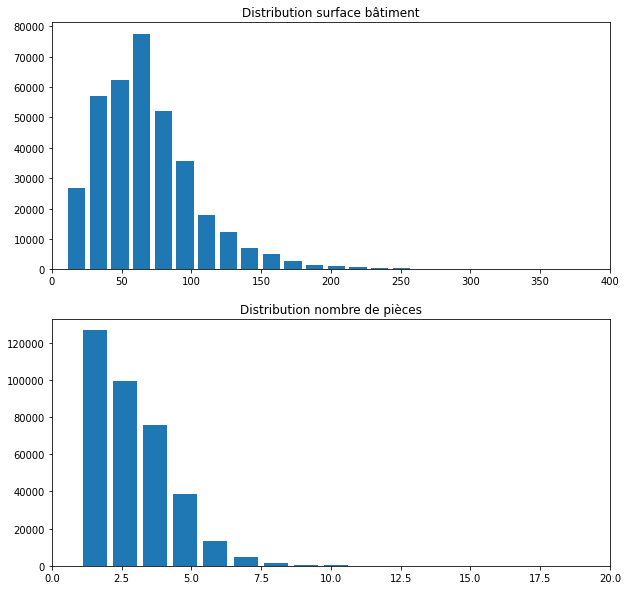

In [11]:
#Distribution de la surface batiment et nombre de pièces:
plt.figure( figsize= (10, 10) )

plt.subplot(2, 1, 1)
plt.hist(locaux["surface_reelle_bati"], bins=100, rwidth=0.8)
plt.xlim([0,400])
plt.title("Distribution surface bâtiment")

plt.subplot(2, 1, 2)
plt.hist(locaux["nombre_pieces_principales"], bins=100, rwidth=0.8)
plt.xlim([0,20])
plt.title("Distribution nombre de pièces");

La majeur partie des bâtiments vendus ont une surface comprise entre 20m² et 150m², et comptent entre 1 et 6 pièces. Il n'y a pratiquement plus aucune valeurs au delas de 250m² et 12 pièces.

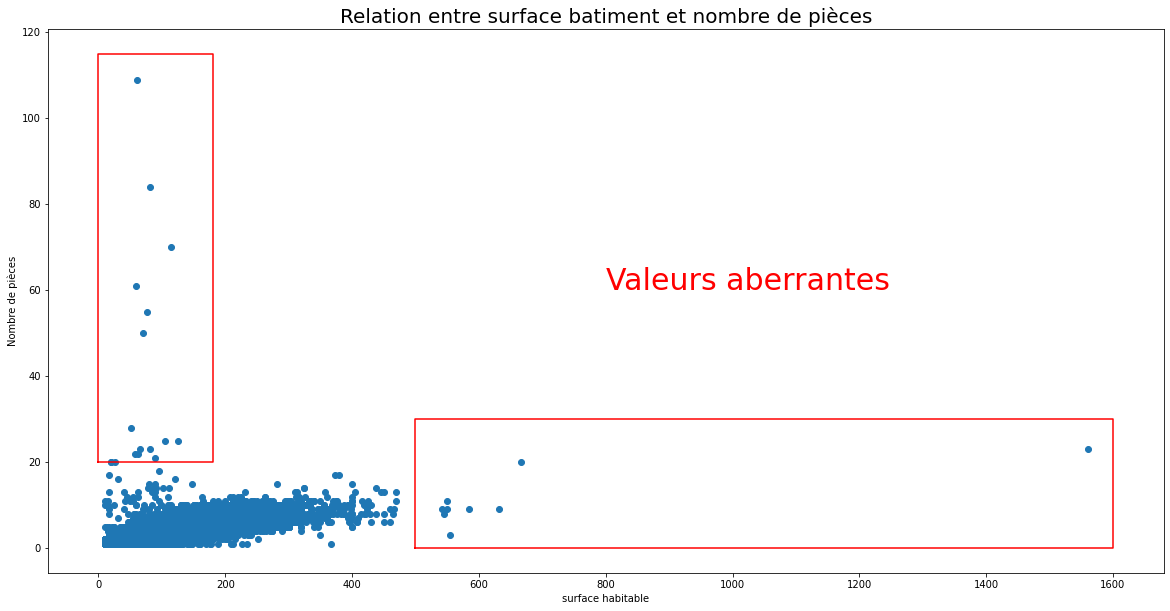

In [12]:
#Nuage de points entre surface bâtiment et nombre de pièces:
plt.figure( figsize= (20, 10) )
plt.scatter(locaux["surface_reelle_bati"], locaux["nombre_pieces_principales"])
plt.plot([0, 180, 180, 0, 0], [20, 20, 115, 115, 20], color="red")
plt.plot([500, 1600, 1600, 500, 500], [0, 0, 30, 30, 0], color="red")
plt.title("Relation entre surface batiment et nombre de pièces", fontsize=20)
plt.xlabel("surface habitable")
plt.ylabel("Nombre de pièces")
plt.text(800, 60,'Valeurs aberrantes', color="red", fontsize=30) ;

Le graphe en nuage de points nous montre des valeurs aberrantes. En effet, il est invraissemblable d'avoir un bâtiment comportant plus de 20 pièces, avec une surface habitable de moins de 200m². De même, une surface habitable de plus de 500m² semble peu vraissemblable.

Au vue des boites à moustaches, de la répartition des données et de la forme du nuage de points, on peut considérer les mutations avec plus de 12 pièces ou plus de 300m² de surface habitable comme outlyers et nous pouvons donc les retirer du dataframe. 

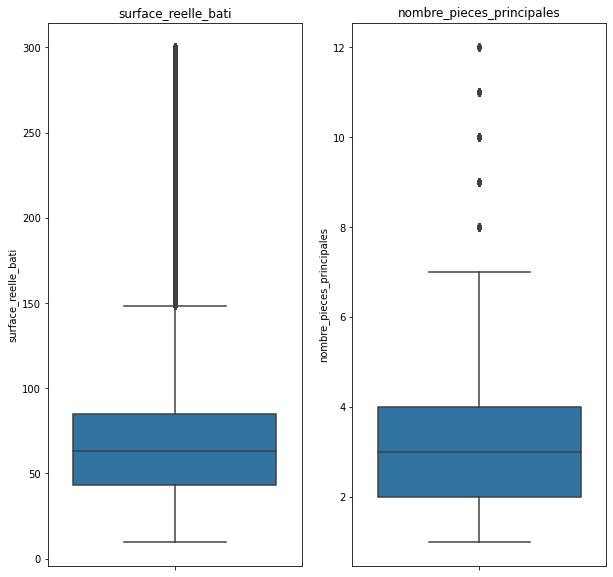

In [13]:
#Récupération de la liste des mutations concernées:
toremove1=locaux[locaux["surface_reelle_bati"]>300]["id_mutation"].unique()
toremove2=locaux[locaux["nombre_pieces_principales"]>12]["id_mutation"].unique()

#Retrait des mutations concernées dans le dataframe:
df=df.loc[df["id_mutation"].isin(toremove1)==False]
df=df.loc[df["id_mutation"].isin(toremove2)==False]

locaux=df[(df["Maison"]+df["Appartement"])!=0]

#Vérification:
fig = plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
sns.boxplot(y=locaux["surface_reelle_bati"])
plt.title("surface_reelle_bati")

plt.subplot(1, 2, 2)
sns.boxplot(y=locaux["nombre_pieces_principales"])
plt.title("nombre_pieces_principales");

# Visualisation des données:

### Relation entre nombre de pièces et surface habitable:

Nous vérifions la corrélation entre le nombre de pièces principale et la surface habitable par un rapide test statistique:

In [14]:
from scipy.stats import pearsonr
corr, p_val=pearsonr(locaux["surface_reelle_bati"], locaux["nombre_pieces_principales"])
print("la P vallue est de " + p_val.astype("str")+" et le pourcentage de corrélation est de " + np.round(corr*100, 1).astype("str")+"%")

la P vallue est de 0.0 et le pourcentage de corrélation est de 85.9%


La P vallue est inférieure à 5% et la corrélation est forte entre le nombre de pièces principale et la surface habitable. Ces deux variables sont donc liées.

### Répartition des biens principaux est secondaires dans les ventes:

Pour rappel:

- Bien principale = Maison, appartement ou terrain à bâtir
- Bien secondaire = Terrain autre ou dépendance.

Nous allons étudier la répartition des types de biens dans les ventes de notre dataframe. 

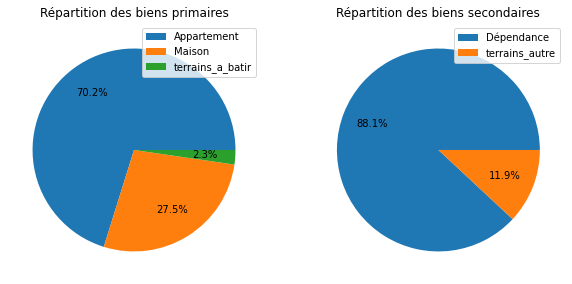

In [15]:
#Répartition des types de biens principaux:
tot_bien_prim=pd.DataFrame(df[["Appartement", "Maison", "terrains_a_batir"]].apply(np.sum, axis = 0), columns=["Nombre"]).reset_index(drop=False).rename({'index' : 'Type'}, axis = 1)

fig = plt.figure(figsize=(10,20))
plt.subplot(1, 2, 1)
plt.pie(tot_bien_prim["Nombre"], 
        labels=tot_bien_prim["Type"], 
        autopct = (lambda a: str(round(a, 1))+"%"), 
        pctdistance =0.7, 
        labeldistance = None)
plt.title("Répartition des biens primaires")
plt.legend()



#Répartition des types de biens secondaires:
tot_bien_sec=pd.DataFrame(df[["Dépendance", "terrains_autre"]].apply(np.sum, axis = 0), columns=["Nombre"]).reset_index(drop=False).rename({'index' : 'Type'}, axis = 1)

plt.subplot(1, 2, 2)
plt.pie(tot_bien_sec["Nombre"], 
        labels=tot_bien_sec["Type"], 
        autopct = (lambda a: str(round(a, 1))+"%"), 
        pctdistance =0.7, 
        labeldistance = None)
plt.title("Répartition des biens secondaires")
plt.legend();

La majeur partie des ventes sont des appartements. Les terrains à bâtir représentent quand à eux une part très faible des ventes. On peut émettre l'hypothèse que cela est due à la forte urbanisation de la région Ile de France. 

Concernant les biens secondaires, ils sont principalement composés de dépendances, mais il n'est pas possible à ce stade de déterminer leur relation avec les biens primaires. 

Nous allons maintenant nous intéresser à la répartition des biens primaires par départements, pour vérifier si la prédomminance des appartements se vérifie à l'échelle des départements.

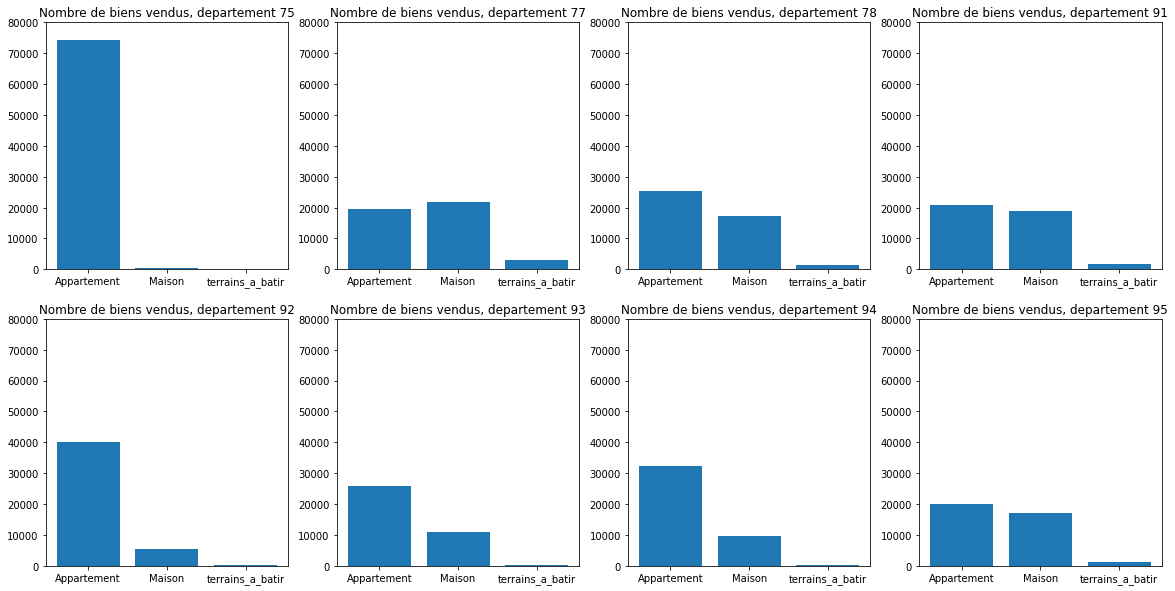

In [16]:
#Liste des départements:
departements=sorted(list(df["code_departement"].unique()))

#Répartition des types de biens principaux par départements:
fig = plt.figure(figsize=(20,10))

for i, dep in zip(range(1, 9), departements):
    title=("Nombre de biens vendus, departement "+dep.astype('int').astype('str'))
    plt.subplot(2, 4, i)
    plt.bar(pd.DataFrame(df[df["code_departement"]==dep][["Appartement", "Maison", "terrains_a_batir"]].apply(np.sum, axis = 0), columns=["Nombre"]).reset_index(drop=False).rename({'index' : 'Type'}, axis = 1)["Type"], 
            pd.DataFrame(df[df["code_departement"]==dep][["Appartement", "Maison", "terrains_a_batir"]].apply(np.sum, axis = 0), columns=["Nombre"]).reset_index(drop=False).rename({'index' : 'Type'}, axis = 1)["Nombre"])
    plt.title(title)
    plt.ylim([0,80000])

- Les ventes dans le département 75 se composent presque exclusivement d'appartements. La zone est donc probablement la plus urbanisée de la région. Il s'agit en effet du département de Paris.

- Les ventes dans les départements 92, 93 et 94 se composent majoritairement d'appartements, et minoritairement de maisons. Presque aucun terrain à bâtir. Ces zones sont donc probablement en grande partie urbanisée. Il s'agit en effet de l'agglomération Parisienne, également appelée "petite couronne".

- Les ventes dans les départements 77, 78, 91 et 95 se composent de maisons et d'appartements de façon équilibrées. Ces zones sont donc probablement les moins urbanisées de la région. Ce sont en effet les départements les plus éloignés de l'agglomération Parisienne. 

Nous pouvons donc conclure que bien que la région soit globalement fortement urbanisée, il y a une disparité d'urbanisation entre les département de la région Ile de France, avec une concentration sur les départements de la "petite couronne": 75, 92, 93 et 94. 

Nous allons maintenant nous intéresser aux biens secondaires. Nous cherchons notemment à savoir quels types de biens secondaire (terrain autre / dépendances) est généralement rattaché à chaque type de biens primaires. 

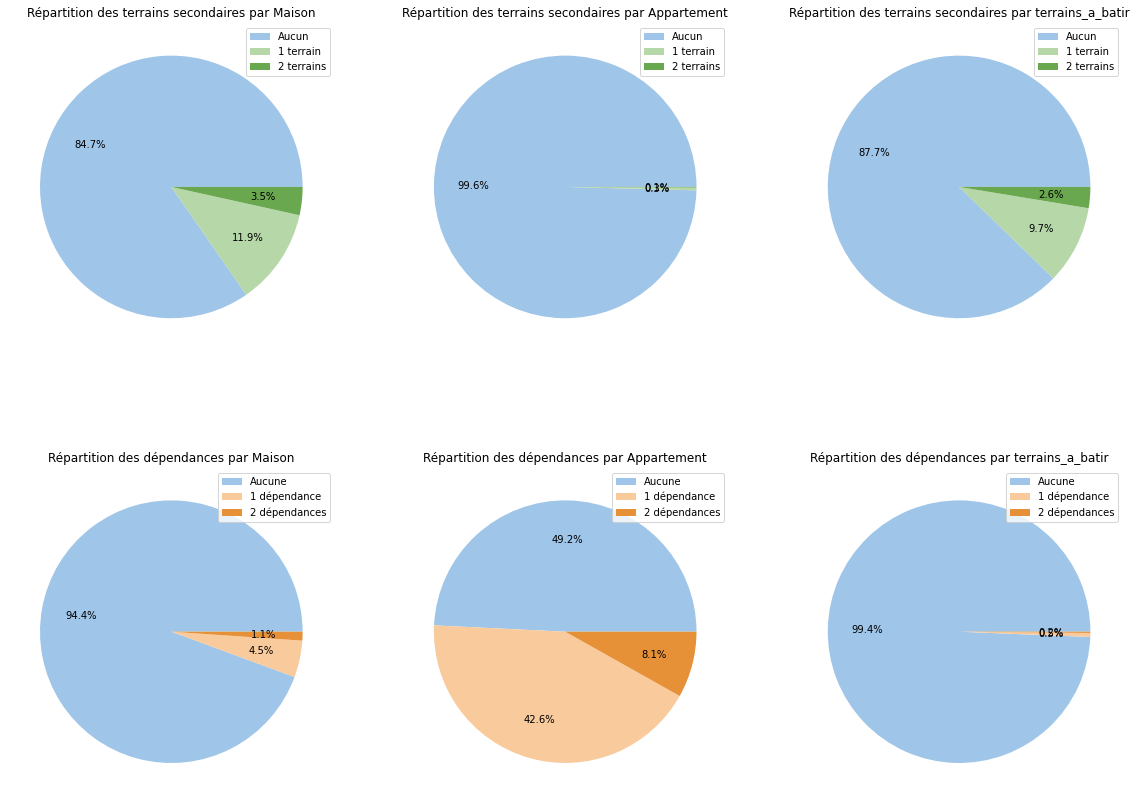

In [17]:
#Liste des types de biens primaires:
biens=["Maison", "Appartement", "terrains_a_batir"]

#Répartition des biens secondaires pour chaque type de bien primaire. 
#Les terrains autre sont représentés avec une couleur verte, les dépendances sont représentées avec une couleur orrange.
fig = plt.figure(figsize=(20,15))

for i, bien in zip(range(1, 4), biens):
    plt.subplot(2, 3, i)
    plt.pie(df[df[bien]==1]["terrains_autre"].value_counts(), 
            labels=["Aucun", "1 terrain", "2 terrains"], 
            colors=["#9fc5e8", "#b6d7a8", "#6aa84f"], 
            autopct = (lambda a: str(round(a, 1))+"%"), 
            pctdistance =0.7, 
            labeldistance = None)
    plt.title("Répartition des terrains secondaires par "+bien)
    plt.legend()


for j, bien in zip(range(4, 7), biens):
    plt.subplot(2, 3, j)
    plt.pie(df[df[bien]==1]["Dépendance"].value_counts(), 
            labels=["Aucune", "1 dépendance", "2 dépendances"], 
            colors=["#9fc5e8", "#f9cb9c", "#e69138"], 
            autopct = (lambda a: str(round(a, 1))+"%"), 
            pctdistance =0.7, 
            labeldistance = None)
    plt.title("Répartition des dépendances par "+bien)
    plt.legend()



- 15% des maisons sont vendues avec 1 ou 2 terrains secondaires et 6% des maisons sont vendues avec 1 ou 2 dépendances.

- Plus de la moitiée des appartements sont vendus avec 1 ou 2 dépendances, mais pratiquement aucun n'est vendu avec un terrain secondaire.

- 12% des terrains à batir sont vendus avec 1 ou 2 terrains secondaires, mais pratiquement aucun n'est vendu avec une dépendance.

Les terrains secondaires sont donc surtout rattachés à des maisons ou des terrains à bâtir, alors que les dépendances sont surtout rattachées à des appartements. On peut émettre l'hypotèse que les appartements sont principalements situés en zones urbanisées, et souvent vendu avec des garages, box ou place de parking séparées du bâtiment principal, expliquant le nombre élevé de dépendance pour ce type de bien. En revanche, les terrains secondaires se retrouvent plus dans des zones peu urbanisée et seraient donc plus souvent rattachés à des maisons ou terrains à bâtir. 

# Corélation des variables avec la variable cible (valeur foncière):

### Table de corrélation globale:

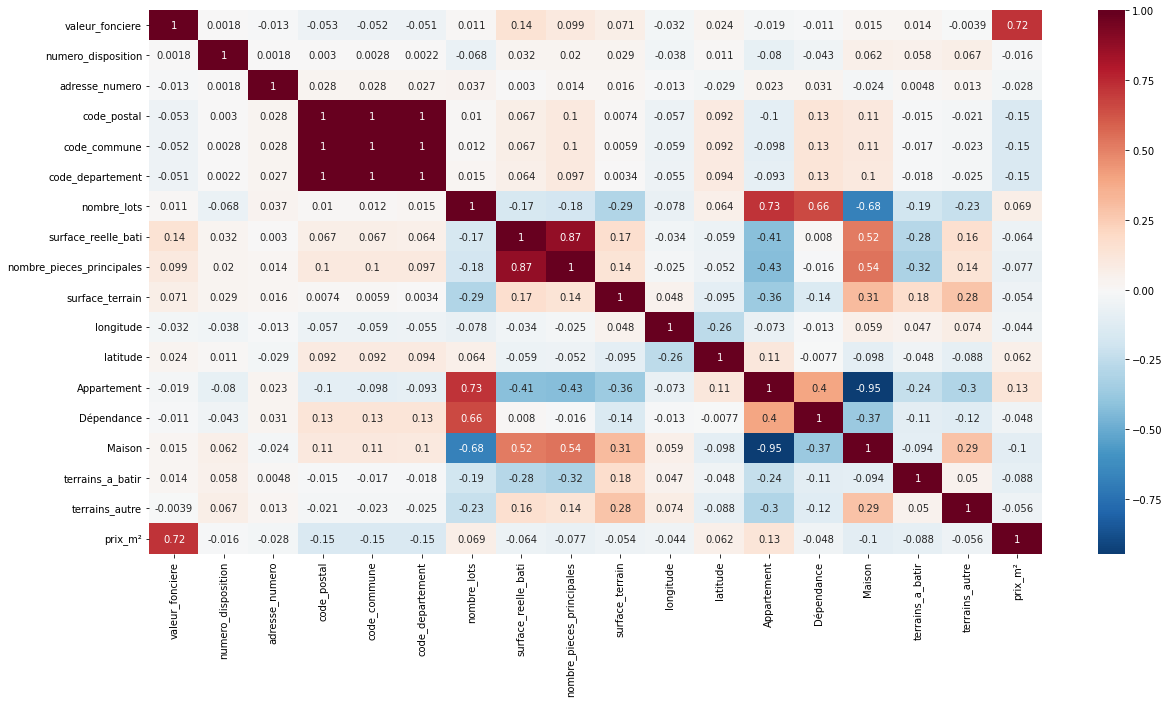

In [18]:
plt.figure( figsize= (20, 10) )
sns.heatmap(df.corr(), cmap="RdBu_r", annot=True, center=0);

En dehors du prix / m², aucune variable ne semble ici significativement correllée à la variable cible. 

### Surface habitable et nombre de pièces:

Nous souhaitons étudier la relation possible entre la surface habitable ("surface_reelle_bati") et le nombre de pièces principales, avec la valeur foncière. La table de corellation globale nous indique que la variable cible n'est significativement correllée à aucune de ces deux variables. Nous soupçonnons que cette abscence de corrélation peut être due une la forte dispartité de prix du marché selon la localisation. Nous allons donc tester cette corrélation à l'échelle globale, à l'échelle d'un département, et à l'échelle d'une commune.

Nous choisissons pour notre visualisation le département du 78 et la commune la plus représenté dans les ventes du département 78.

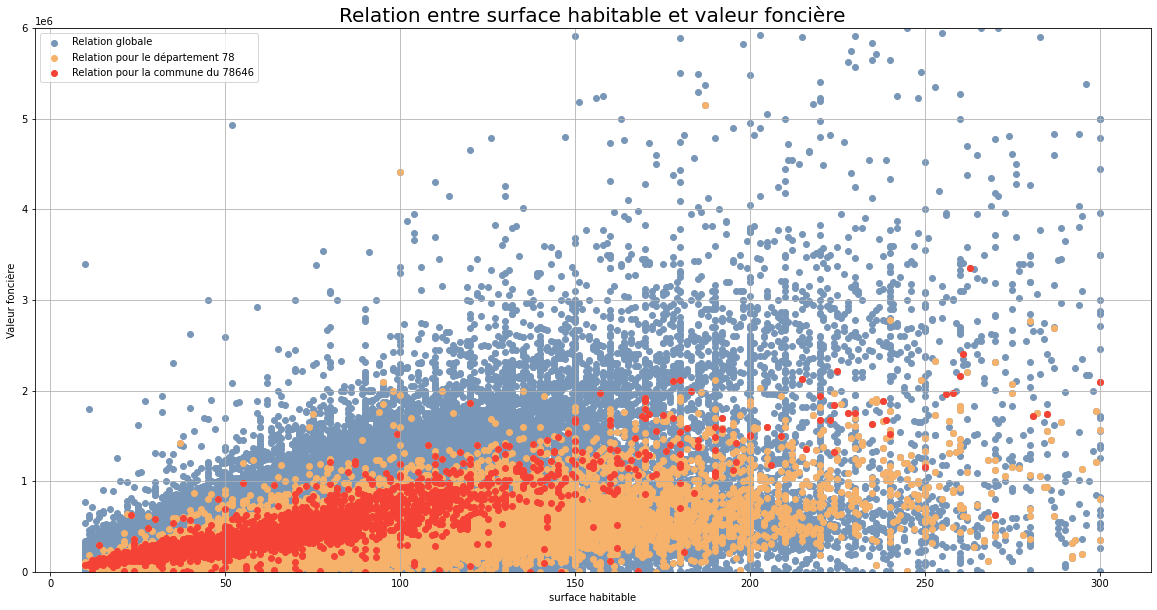

In [19]:
#Données du département 78:
locaux_78=locaux[locaux["code_departement"]==78]

#Données de la commune la plus représenté dans les ventes dans le 78:
commune_78=locaux_78["code_commune"].mode()[0].astype("int")
locaux_commune_78=locaux[locaux["code_commune"]==commune_78]

#Nuage de points entre surface bâtiment et valeur foncière:
plt.figure( figsize= (20, 10) )
plt.scatter(locaux["surface_reelle_bati"], locaux["valeur_fonciere"], color="#7896b7", label="Relation globale")
plt.scatter(locaux_78["surface_reelle_bati"], locaux_78["valeur_fonciere"], color="#f6b26b", label="Relation pour le département 78")
plt.scatter(locaux_commune_78["surface_reelle_bati"], locaux_commune_78["valeur_fonciere"], color="#f44336", label=("Relation pour la commune du "+commune_78.astype("str")))
plt.title("Relation entre surface habitable et valeur foncière", fontsize=20)
plt.xlabel("surface habitable")
plt.ylabel("Valeur foncière")
plt.ylim([0,6000000])
plt.legend()
plt.grid();

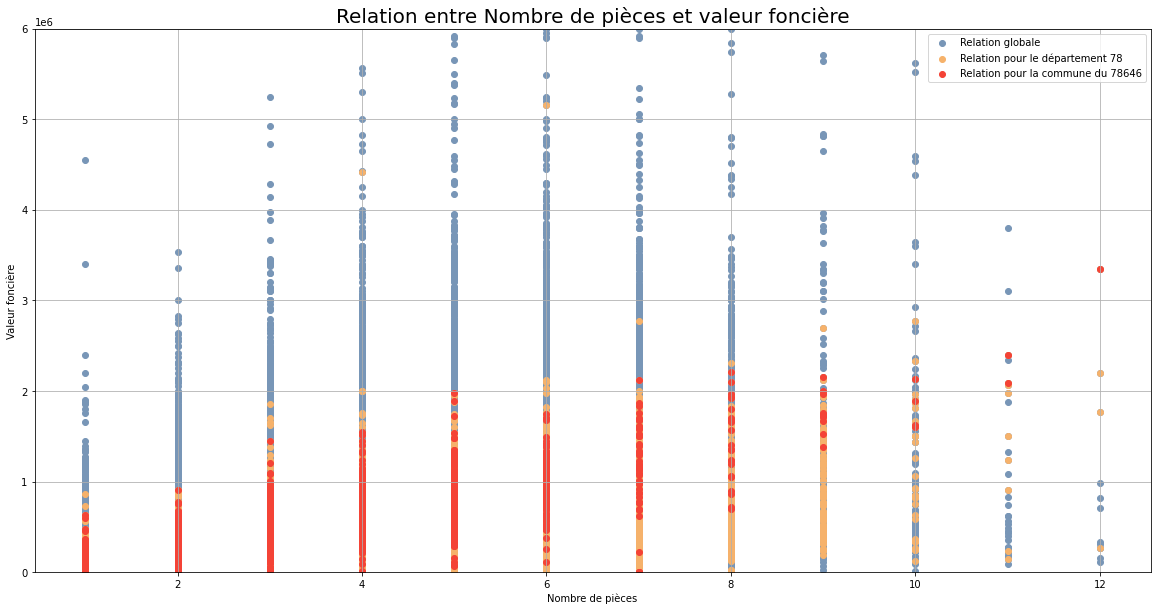

In [20]:
#Nuage de points entre Nombre de pièces et valeur foncière:

plt.figure( figsize= (20, 10) )
plt.scatter(locaux["nombre_pieces_principales"], locaux["valeur_fonciere"], color="#7896b7", label="Relation globale")
plt.scatter(locaux_78["nombre_pieces_principales"], locaux_78["valeur_fonciere"], color="#f6b26b", label="Relation pour le département 78")
plt.scatter(locaux_commune_78["nombre_pieces_principales"], locaux_commune_78["valeur_fonciere"], color="#f44336", label=("Relation pour la commune du "+commune_78.astype("str")))
plt.title("Relation entre Nombre de pièces et valeur foncière", fontsize=20)
plt.xlabel("Nombre de pièces")
plt.ylabel("Valeur foncière")
plt.ylim([0,6000000])
plt.legend()
plt.grid();

A l'échèle globale, le nuage de points est fortement dispersé, confirmant la faible corrélation entre la variable cible et la surface habitable ou le nombre de pièces, à l'échelle globale. En revanche, lorsqu'on regarde à l'échelle du département, puis de la commune, la corrélation se montre de plus en plus visible, car les points semblent de plus en plus allignés sur une droite. 

Notre hypothèse d'une forte variation du prix du marché selon la localisation créant une forte dispersion à l'échelle globale semble donc plosible. Pour la vérifier, nous disposons de la variable du prix / m² pour chaque ventes. Nous allons vérifier quelle est la valeur moyenne du prix / m² pour chaque départements.

## Création des colonnes sections cadastrale,  commune et calcul de la moyenne du prix au m²

### Création des sections cadastrale et  sections commune 

 Nous avons créé la colonne section cadastrale  à partir de le colonne id_parcelle, puis nous avons calculé  le prix m² moyen

c'est quoi une section cadastrale ? 

Une section cadastrale est une partie du territoire communal, son périmètre est constitué dans la mesure du possible par des limites présentant un caractère suffisant de stabilité (ex : routes, chemins, cours d'eau, fossés, etc.)

Donc une commune est divisée en plusieurs sections cadastrales  et cette dernière est subdivisée en parcelles (bien foncier))

Le N° de section cadastrale n'est pas présent dans notre dataframe. La variable ID de parcelle dans notre dataframe nous permet de créer le N° de section cadastrale. En effet, l'ID de parcelle est un numéro composé du code commune, du numéro de section cadastrale et d'un numéro de parcelle. Nous allons donc créer une colonne section cadastrale en récupérant les 10 premiers carractères de l'ID de parcelle. 

In [21]:
#création  de section cadastrale a partir de id_parcelle  

df['section_cadastrale'] = df['id_parcelle'].str.slice(0,10)

In [22]:
df.head()

,id_mutation,valeur_fonciere,date_mutation,numero_disposition,nature_mutation,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,id_parcelle,nombre_lots,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,Appartement,Dépendance,Maison,terrains_a_batir,terrains_autre,prix_m²,section_cadastrale
0,2019-1135463,310000.0,2019-01-03,1.0,Vente,11.0,NaN,RUE DE LA FONTAINE,0650,77220.0,77215.0,Gretz-Armainvilliers,77.0,772150000B0473,0,101.0,4.0,855.0,2.740574,48.739669,0.0,0.0,1,0.0,1.0,3069.31,772150000B
1,2019-1135466,155000.0,2019-01-04,1.0,Vente,4.0,NaN,AV DE LA GARE,0600,77340.0,77373.0,Pontault-Combault,77.0,77373000AD0157,2,51.0,2.0,0.0,2.616840,48.805639,1.0,1.0,0,0.0,0.0,3039.22,77373000AD
2,2019-1135467,165500.0,2019-01-09,1.0,Vente,45.0,NaN,RUE LOUIS VICTOR DE BROGLIE,1413,77176.0,77445.0,Savigny-le-Temple,77.0,77445000YA0444,3,64.0,3.0,12.0,2.565832,48.605740,1.0,2.0,0,0.0,0.0,2585.94,77445000YA
3,2019-1135468,269000.0,2019-01-02,1.0,Vente,6.0,NaN,RUE JEAN FERRAT,0492,77310.0,77407.0,Saint-Fargeau-Ponthierry,77.0,77407000AY0353,0,84.0,4.0,270.0,2.553743,48.530118,0.0,0.0,1,0.0,2.0,3202.38,77407000AY
4,2019-1135469,199500.0,2019-01-08,1.0,Vente,3.0,NaN,RUE DE LA PICARDIE,0186,77720.0,77211.0,Grandpuits-Bailly-Carrois,77.0,772110170D0147,0,109.0,5.0,1036.0,2.993174,48.576719,0.0,0.0,1,0.0,2.0,1830.28,772110170D


### Calcul de le moynne du prix au m²

 Nous allons maintenant calculer la moyenne de prix m² par section cadastrale et par commune

In [23]:
#calcule de prix moyen de m2 par section cadastrale, par commune
prix_m2_moyen_section_cadastrale = df.groupby(['section_cadastrale'],as_index = True).agg({'prix_m²':'mean'})
prix_m2_moyen_section_commune = df.groupby(['code_commune'],as_index = True).agg({'prix_m²':'mean'})


#fusion des dataframe 

df = pd.merge(df,prix_m2_moyen_section_cadastrale, on = 'section_cadastrale', how ='left', suffixes=('_x','_y'))
df = pd.merge(df,prix_m2_moyen_section_commune, on = 'code_commune', how ='left')

#modification des noms de colonnes 
df = df.rename(columns={"prix_m²_x": "prix_m²", "prix_m²_y": "prix_m²_moy_ca", "prix_m²": "prix_m²_moy_co"})

#check des valeur manquantes 
print("il y'a " ,df['section_cadastrale'].isna().sum(), "valeurs manquantes")
print("il y'a " ,df['code_commune'].isna().sum(), "valeurs manquantes")


il y'a  0 valeurs manquantes
il y'a  0 valeurs manquantes


## Analyse du  prix / m²  moyen (ca, co) par departement 

Abréviation :

co : commune 

ca : section cadastral 


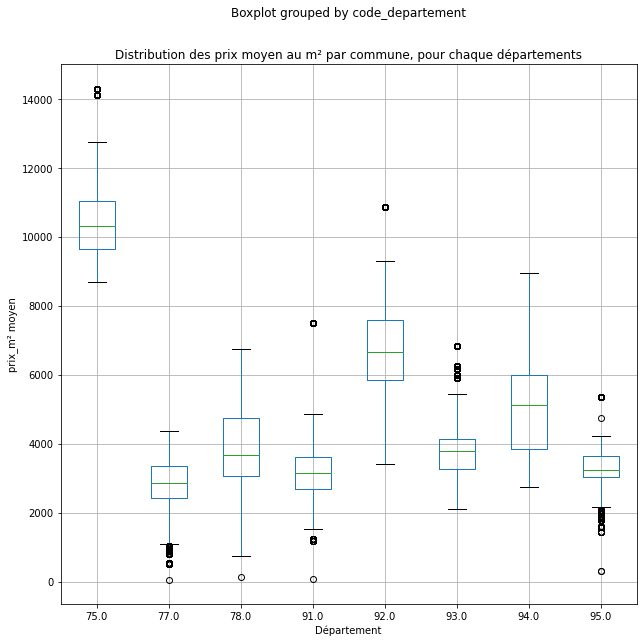

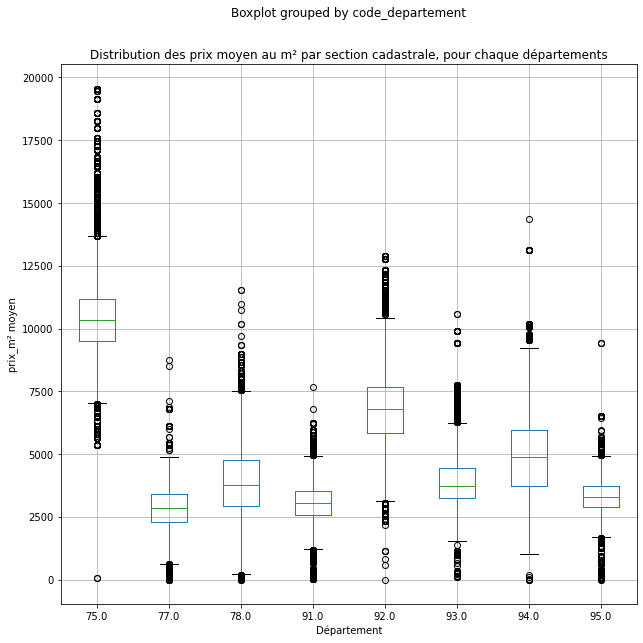

In [24]:
df.boxplot(column = ['prix_m²_moy_co'], by='code_departement', figsize= (10,10), grid = True)
plt.xlabel("Département")
plt.ylabel("prix_m² moyen")
plt.title("Distribution des prix moyen au m² par commune, pour chaque départements")

df[df['prix_m²_moy_ca']<20000].boxplot(column = ['prix_m²_moy_ca'], 
                                       by='code_departement', figsize= (10,10), grid = True)
plt.xlabel("Département")
plt.ylabel("prix_m² moyen")
plt.title("prix moyen de m² par département")
plt.title("Distribution des prix moyen au m² par section cadastrale, pour chaque départements");

le prix_m² moyen est autour de 12000 euro pour le département 75 suivis par le 92, 94 pour un prix entre 5 000 et 7 000 euros, pour le reste des département le prix est situer entre 2000 - 4000 euros.

Le prix / m² dans le département 75 (Paris) est plus de 3 fois plus chère que dans le département du 77. Cela confirme la forte disparité entre départements.

Nous allons maintenant étudier la disparité de prix / m² entre les communes d'un département. Nous choisissons le département du 78. Pour faciliter la lecture, nous n'afficherons que les 10 communes les plus chères et les 10 communes les moins chères.

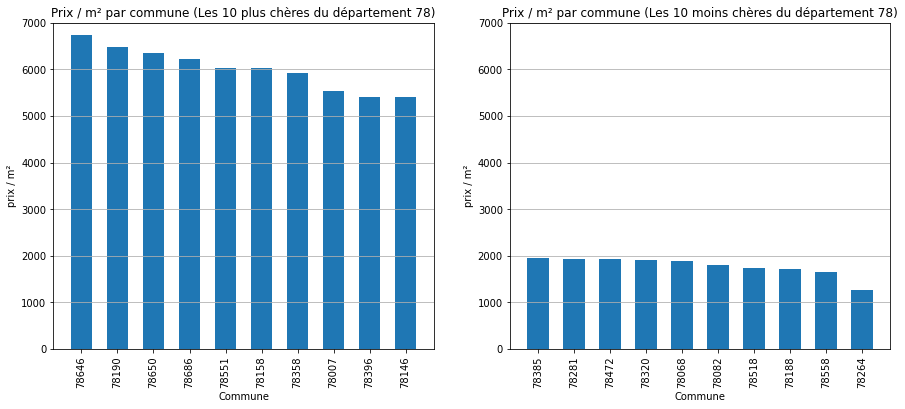

In [25]:
#Prix / m² par communes (les 10 plus chères et 10 moins chères du département 78):

com=locaux_78[["code_commune", "prix_m²"]].groupby("code_commune", as_index = True).mean().sort_values(by = "prix_m²", ascending = False)

plt.figure( figsize= (15, 6) )

plt.subplot(1, 2, 1)
plt.bar(com.head(10).index.astype("int").astype("str"), com.head(10)["prix_m²"], width=0.6)
plt.title("Prix / m² par commune (Les 10 plus chères du département 78)")
plt.xlabel("Commune")
plt.ylabel("prix / m²")
plt.ylim(0, 7000)
plt.xticks(rotation=90)
plt.grid(axis="y")

plt.subplot(1, 2, 2)
plt.bar(com.tail(10).index.astype("int").astype("str"), com.tail(10)["prix_m²"], width=0.6)
plt.title("Prix / m² par commune (Les 10 moins chères du département 78)")
plt.xlabel("Commune")
plt.ylabel("prix / m²")
plt.ylim(0, 7000)
plt.xticks(rotation=90)
plt.grid(axis="y");

La commune la plus chère est près de 6 fois plus chère que la commune la moins chère. Notre hypothèse se vérifie donc égallement à l'échelle de la commune. 

Nous savons maintenant que des corrélations significatives avec la variables cible ne sont visibles qu'à partire de l'échelle de la commune. Nous pouvons donc visualiser de nouveau la table de corrélation de notre dataframe, mais cette fois ci, nous la regardons pour une sélection aléatoire de 5 communes parmis les 200 communes les plus représentés (ayant le plus de ventes) dans notre dataframe:

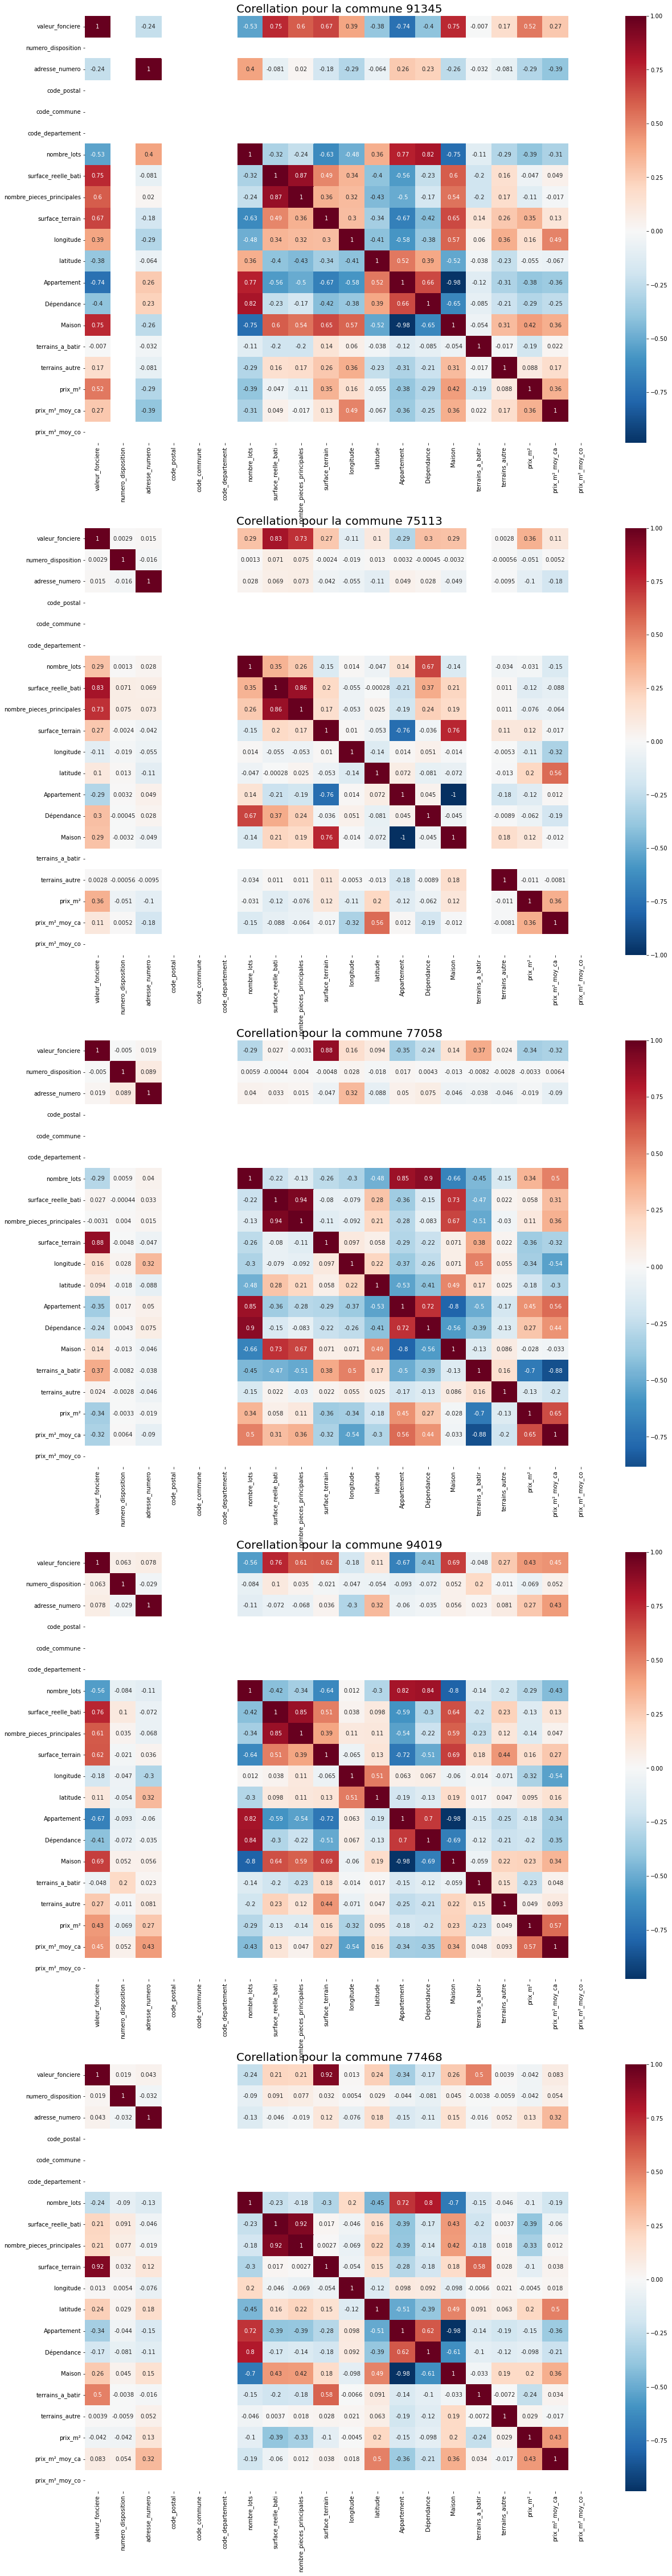

In [26]:
#Sélection de 5 communes parmis les 200 communes les plus représentés dans notre dataframe:
from random import sample
sample_com=sample(list(df["code_commune"].value_counts().head(200).index), 5)

#Heatmap pour chacune des 5 communes sélectionnées:
plt.figure( figsize= (20, 80) )

for i, com in zip(range(1, 6), sample_com):
    plt.subplot(5, 1, i)
    sns.heatmap(df[df["code_commune"]==com].corr(), cmap="RdBu_r", annot=True, center=0)
    plt.title("Corellation pour la commune "+str(int(com)), fontsize=20);

Nous notons des corrélations assez variables d'une commune à l'autre, laissant supposer qu'il pourrait rester de fortes disparités de prix / m² au sein d'une même commune, entre plusieurs quartiers par exemple. Mais nous pouvons tout de même remarquer que les variables revenant le plus souvent comme les plus correllées à la variable cible sont:

- surface_reelle_bati (Surface habitable)
- nombre_de_pieces_principales
- surface_terrain
- prix_m²

Nous remarquons également que les variables "Maison" et "Appartement" ont la plupart du temps une correllation avec la cible de grandeur similaire, mais positive pour "Maison" et négative pour "Appartement". On pourrait donc penser que les biens de type Maison ont un prix de vente généralement supérieur à un appartement, à surface habitable égale. 

### Evolution du prix dans le temps

Nous souhaitons maintenant étudier la variation de la valeur foncière et du prix au mètre carré selon les années. Nous commencons par extraire l'année de la variable date de mutation. Nous ne souhaitons pas étudier la variation par mois pour le moment.

In [27]:
df['date_mutation'] = pd.to_datetime(df['date_mutation'])   # consertion en Datetime globalement plus pratique
df['annee'] = df['date_mutation'].dt.year                   # annee de type int
df['code_annee'] = df['annee'].replace(to_replace=[2019,2020,2021], value=[0,1,2])

Re-création d'une variable type_bien (principal) pour la Dataviz (principalement).

In [28]:
df.loc[df["Maison"]==1, "type_bien"]="Maison"
df.loc[df["Appartement"]==1, "type_bien"]="Appartement"
df.loc[df["terrains_a_batir"]==1, "type_bien"]="Terrain"
df.head()

,id_mutation,valeur_fonciere,date_mutation,numero_disposition,nature_mutation,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,id_parcelle,nombre_lots,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,Appartement,Dépendance,Maison,terrains_a_batir,terrains_autre,prix_m²,section_cadastrale,prix_m²_moy_ca,prix_m²_moy_co,annee,code_annee,type_bien
0,2019-1135463,310000.0,2019-01-03,1.0,Vente,11.0,NaN,RUE DE LA FONTAINE,0650,77220.0,77215.0,Gretz-Armainvilliers,77.0,772150000B0473,0,101.0,4.0,855.0,2.740574,48.739669,0.0,0.0,1,0.0,1.0,3069.31,772150000B,3646.883495,3474.511880,2019,0,Maison
1,2019-1135466,155000.0,2019-01-04,1.0,Vente,4.0,NaN,AV DE LA GARE,0600,77340.0,77373.0,Pontault-Combault,77.0,77373000AD0157,2,51.0,2.0,0.0,2.616840,48.805639,1.0,1.0,0,0.0,0.0,3039.22,77373000AD,3804.018010,3759.720085,2019,0,Appartement
2,2019-1135467,165500.0,2019-01-09,1.0,Vente,45.0,NaN,RUE LOUIS VICTOR DE BROGLIE,1413,77176.0,77445.0,Savigny-le-Temple,77.0,77445000YA0444,3,64.0,3.0,12.0,2.565832,48.605740,1.0,2.0,0,0.0,0.0,2585.94,77445000YA,2821.665116,2610.471778,2019,0,Appartement
3,2019-1135468,269000.0,2019-01-02,1.0,Vente,6.0,NaN,RUE JEAN FERRAT,0492,77310.0,77407.0,Saint-Fargeau-Ponthierry,77.0,77407000AY0353,0,84.0,4.0,270.0,2.553743,48.530118,0.0,0.0,1,0.0,2.0,3202.38,77407000AY,2815.332174,2679.428891,2019,0,Maison
4,2019-1135469,199500.0,2019-01-08,1.0,Vente,3.0,NaN,RUE DE LA PICARDIE,0186,77720.0,77211.0,Grandpuits-Bailly-Carrois,77.0,772110170D0147,0,109.0,5.0,1036.0,2.993174,48.576719,0.0,0.0,1,0.0,2.0,1830.28,772110170D,2360.692500,2020.605714,2019,0,Maison


Corrections du types pour certaines variables

In [29]:

df['numero_disposition'] = df['numero_disposition'].astype('object')
df['adresse_numero'] = df['adresse_numero'].astype('object')
df['code_postal'] = df['code_postal'].astype('object')
df['nombre_lots'] = df['nombre_lots'].astype('object')
df['longitude'] = df['longitude'].astype('object')
df['latitude'] = df['latitude'].astype('object')
df['annee'] = df['annee'].astype('object')

df['code_departement'] = df['code_departement'].astype('int')
df['code_commune'] = df['code_commune'].astype('int')

df['Appartement'] = df['Appartement'].astype('int')
df['Dépendance'] = df['Dépendance'].astype('int')
df['terrains_a_batir'] = df['terrains_a_batir'].astype('int')
df['terrains_autre'] = df['terrains_autre'].astype('int')


#### Analyse de l'année de mutation et de son impact éventuel sur le prix au m2

###### Distribution du prix au m2

In [30]:
df['prix_m²'].describe()

count    3.685710e+05
mean     5.511792e+03
std      8.450477e+03
min      0.000000e+00
25%      2.957140e+03
50%      4.235180e+03
75%      7.487460e+03
max      3.567582e+06
Name: prix_m², dtype: float64

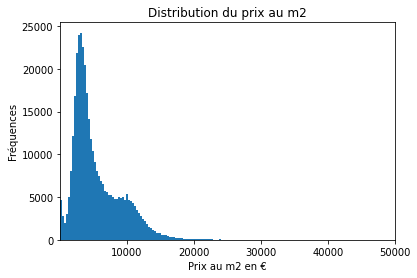

In [31]:
df[df['prix_m²'].between(100,30000)]['prix_m²'].plot.hist(xlim=(100,50000), bins=100, 
                                                          title="Distribution du prix au m2")
plt.xlabel("Prix au m2 en €")
plt.ylabel("Fréquences");

#### Nota : nous retenons 25 000€ comme prix au m2 maximum... et 100€ minimum pour écarter les ventes à l'euro symbolique.

###### boxplot correspondant aux bornes choisies (100 €, 25 000 €)

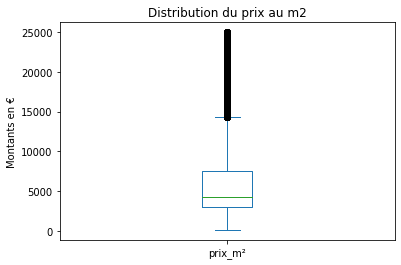

In [32]:
df[df['prix_m²'].between(100,25000)]['prix_m²'].plot.box(title="Distribution du prix au m2")
plt.ylabel("Montants en €");

#### Suppresion des mutations dont les prix au m2 sont hors limites fixées (100 €, 25 000 €)

In [33]:
df=df[df['prix_m²'].between(100,25000)]

#### Visualisation de l'évolution du prix au m2 par année

###### Modification de types pour dataviz 

In [34]:
df['code_departement'] = df['code_departement'].astype('str')
df['annee'] = df['annee'].astype('str')

###### Tri préalable par année et par département

In [35]:
df2 = df.sort_values(by=['annee','code_departement'])

###### Evolution des prix au m2 sur les 3 années d'étude (selon les départements)

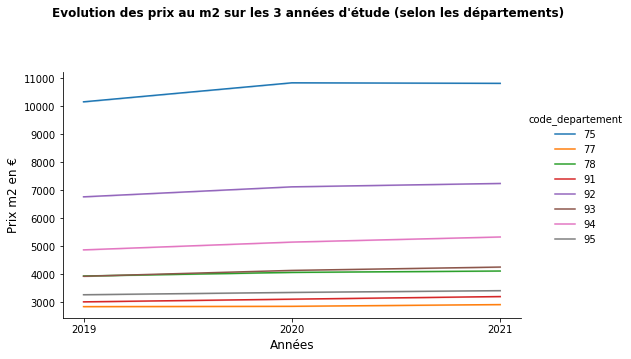

In [36]:
ax = sns.relplot(data=df2,x='annee',y='prix_m²',kind='line', hue='code_departement', 
                 height = 5, aspect = 1.5, ci=False)        # , legend=None

ax.fig.subplots_adjust(top=0.8)
ax.fig.suptitle("Evolution des prix au m2 sur les 3 années d'étude (selon les départements)",fontsize=12, fontweight='bold')

ax.set_xlabels('Années', fontsize=12)
ax.set_ylabels('Prix m2 en €', fontsize=12)

plt.show();


Nous remarquons une très légère évolution des prix au m2 sur les 3 années. 

#### Analyse statistique : prix m2 et code_annee sont-ils indépendants ?
###### 2 var numériques -> test de Pearson... 

In [37]:

pearsonr(df2['prix_m²'],df2['code_annee'])
# Il renvoie le coefficient et la p-value du test

(0.030855599322093683, 1.0157477285201432e-77)

Test de Pearson < 5%                    => On rejette H0 : variables dépendantes  
Coefficient de Pearson proche de 0     => donc faiblement dépendantes
#### => L'année de mutation impacte très peu le prix au m2

#### Distribution de la variable valeur_fonciere

In [38]:
df['valeur_fonciere'].describe()

count    3.656180e+05
mean     3.553014e+05
std      4.216836e+05
min      5.000000e+02
25%      1.779000e+05
50%      2.680000e+05
75%      4.090000e+05
max      9.180000e+07
Name: valeur_fonciere, dtype: float64

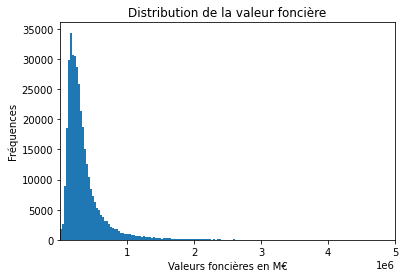

In [39]:
df[df['valeur_fonciere'].between(100,3000000)]['valeur_fonciere'].plot.hist(xlim=(100,5000000), bins=100,
                                                                           title="Distribution de la valeur foncière")
plt.xlabel("Valeurs foncières en M€")
plt.ylabel("Fréquences");


#### Nota : nous retenons 3 M€ pour la valeur foncière maximum... et toujours 100€ pour le minimum.

###### Boxplot correspondant aux bornes choisies (100 €,3 000 000 €)

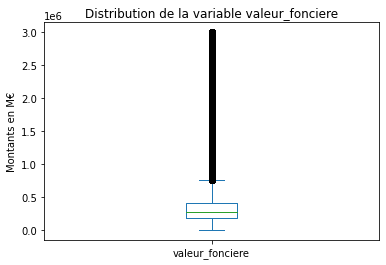

In [40]:
df[df['valeur_fonciere'].between(100,3000000)]['valeur_fonciere'].plot.box(title="Distribution de la variable valeur_fonciere")
plt.ylabel("Montants en M€");


#### Suppresion des mutations dont les valeurs foncières sont hors limites fixées (100 €,3 000 000 €)

In [41]:
df = df[df['valeur_fonciere'].between(100,3000000)]

#### Visualisation des valeurs foncières par type de bien (selon les départements)

###### Tri préalable par département

In [42]:
df3 = df.sort_values(by='code_departement')

###### Valeurs foncières par type de bien (selon le département)

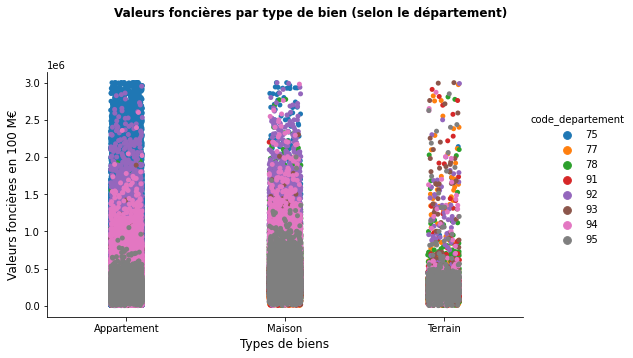

In [43]:
ax = sns.catplot(data=df3,x='type_bien',y='valeur_fonciere', hue='code_departement', aspect=1.5)   # , legend=None

ax.fig.subplots_adjust(top=0.8)                                                
ax.fig.suptitle('Valeurs foncières par type de bien (selon le département)',fontsize=12, fontweight='bold')

ax.set_xlabels('Types de biens', fontsize=12)
ax.set_ylabels('Valeurs foncières en 100 M€', fontsize=12)

plt.show();


#### Nota : nous retrouvons les constatations précédentes :
###### forte présence d'appartements à prix très élevés dans le 75, à prix "moyens" dans les 92, 94
###### moins d'offres de maisons à prix élevés, vie citadine -> appartement
###### et encore moins d'offre de terrains à prix élevés (mais présence un peu dans tous les départements sauf 75)

#### Distribution de la Valeur foncière par type de bien

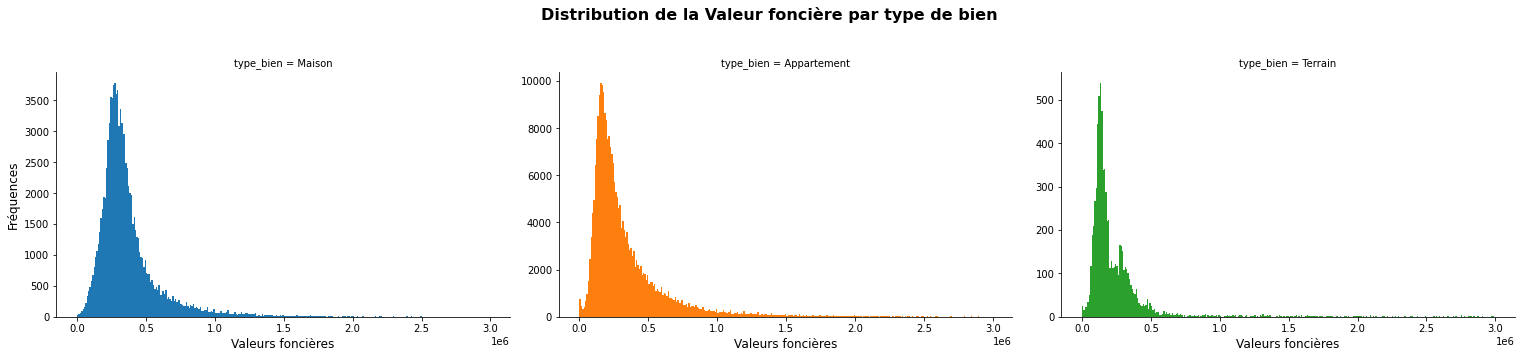

In [44]:
ax = sns.FacetGrid(data=df, col='type_bien', height=5, aspect=1.4, hue='type_bien', sharey=False)

ax.map(plt.hist,'valeur_fonciere', bins=np.arange(100,3000000,10000))          

ax.fig.subplots_adjust(top=0.8)                                                
ax.fig.suptitle('Distribution de la Valeur foncière par type de bien',fontsize=16, fontweight='bold')

ax.set_xlabels('Valeurs foncières', fontsize=12)
ax.set_ylabels('Fréquences', fontsize=12)

plt.show();


#### Nota : Bonne allure des courbes pour notre future variable cible... 

#### Analyse brute de la date_mutation après filtrage initial des données
###### La question étant : avons-nous engendré des pertes de données dans le dataset suite aux étapes de filtrages dans le notebook gouvimmo_project_part2 ?

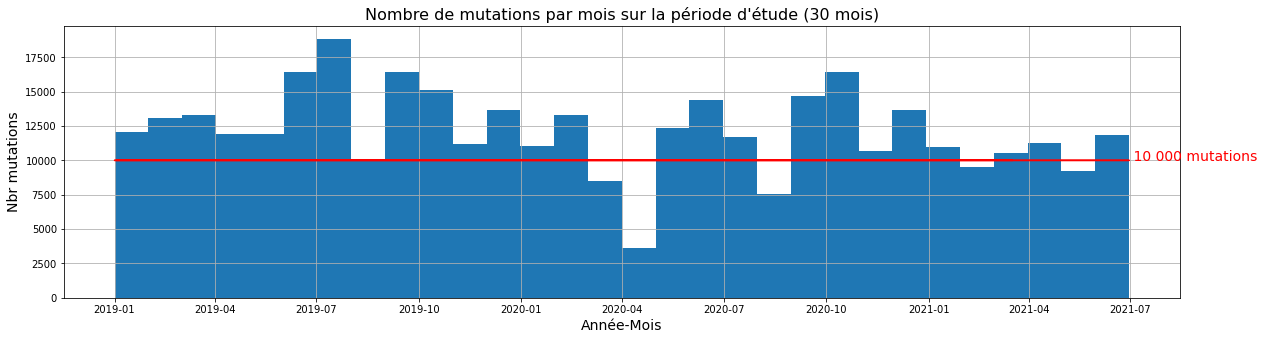

In [45]:
plt.figure(figsize = (20,5))
plt.title("Nombre de mutations par mois sur la période d'étude (30 mois)", size=16)
plt.xlabel("Année-Mois", size=14)
plt.ylabel("Nbr mutations", size=14)
plt.plot(df['date_mutation'].values,np.linspace(10000,10000,len(df)), c='red')
plt.text(df['date_mutation'].max(),10000," 10 000 mutations",c='red',size=14)
df['date_mutation'].hist(bins=30);

#### Nota : nous avons pratiquement toujours 10 000 mutations par mois, sauf en mars/avril/aout 2020 et fev/mai 2021
###### mars-avril/2020 : début du confinement covid...
###### aout-dec : toujours des 'petits' mois (vacances)
#### Pas de perte de données suite aux filtrages, nous avions fait le même constat sur les données brutes

#### Analyse de la date_mutation après filtrage initial des données (et avec regroupement)
###### La question étant : le flux de mutations sur un mois est-il régulier ?

In [46]:
df4 = df[['date_mutation']].groupby('date_mutation',as_index=False).mean()

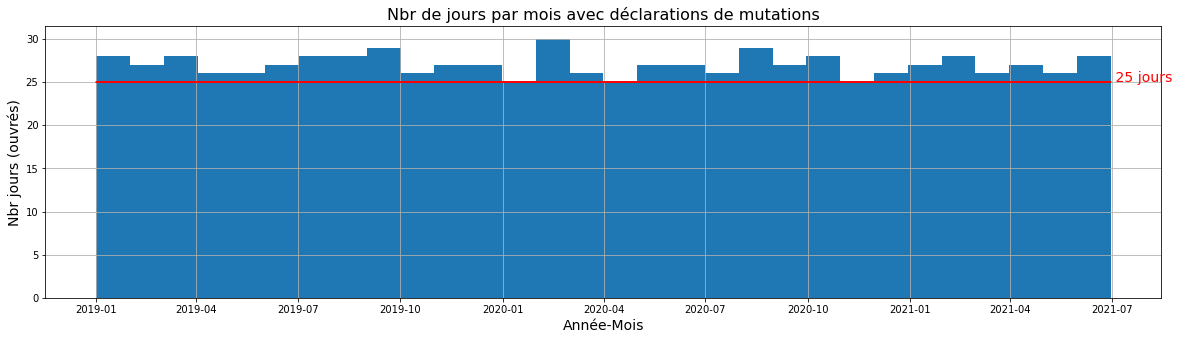

In [47]:
plt.figure(figsize = (20,5))
plt.title("Nbr de jours par mois avec déclarations de mutations", size=16)
plt.xlabel("Année-Mois", size=14)
plt.ylabel("Nbr jours (ouvrés)", size=14)
plt.plot(df['date_mutation'].values, np.linspace(25,25,len(df)), c='red')
plt.text(df['date_mutation'].max(),25," 25 jours",c='red', size=14)
df4['date_mutation'].hist(bins=30);

#### Nota : nous observons des déclatations de mutations entre 25 et 30 jours par mois... 
###### donc pratiquement tous les jours ouvrables... 
#### Flux de données par mois, conservé

### Etude des variables de localisation d'un bien principal

###### Nota : nous avons décidé d'écarter l'adresse postale, ainsi que longitude / latitude, dans un premier temps.
######            nous nous concentrons donc sur le département, la commune et la section cadastrale.

###### Decompte du nombre de sections cadastrales et du nombre de communes par département.

In [48]:
df11 = df.groupby(['code_departement','code_commune'],as_index=False).agg({'section_cadastrale':'unique'})
df11['nb_section'] = df11['section_cadastrale'].apply(lambda x: len(x))
df12 = df.groupby(['code_departement'],as_index=False).agg({'code_commune':'unique'})
df12['nb_commune'] = df12['code_commune'].apply(lambda x: len(x))
df13 = pd.merge(left=df12,right=df11,on='code_departement')
df13.drop(['code_commune_x','section_cadastrale'],axis=1, inplace=True)
df13.rename(columns={'code_commune_y': 'code_commune'}, inplace = True)
df14 = df13.groupby(['code_departement'],as_index=False).agg({'nb_commune':'mean', 'nb_section':'sum'})

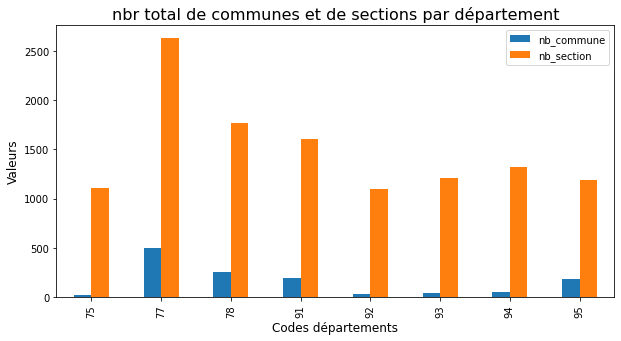

In [49]:
df14[['code_departement','nb_commune','nb_section']].plot.bar(x='code_departement',figsize = (10,5))
plt.title("nbr total de communes et de sections par département", size=16)
plt.xlabel("Codes départements",size=12)
plt.ylabel("Valeurs",size=12);

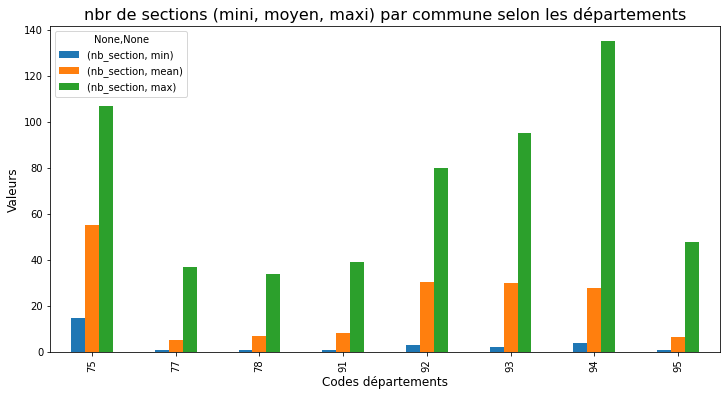

In [50]:
df15 = df13.groupby(['code_departement'],as_index=False).agg({'nb_section':['min','mean','max']})
df15[['code_departement','nb_section']].plot.bar(x='code_departement',figsize = (12,6))
plt.title("nbr de sections (mini, moyen, maxi) par commune selon les départements", size=16)
plt.xlabel("Codes départements",size=12)
plt.ylabel("Valeurs",size=12);

###### Nota : On retrouve de nouveau le fait que le 75 est très urbanisé avec un grand nombre moyen de sections (de petites tailles ?),
######            les départements 92 93 94 sont moyennement urbanisés, les 77 78 91 95 sont les moins urbanisés. 

# Mise en place du data frame de travail pour comprendre la part des acquisitions de biens primaires(appartements, maisons et terrains à bâtir) par département dans la région Ile De France

In [51]:

df1 = df[['Appartement', 'Maison', 'terrains_a_batir', 'terrains_autre', 'Dépendance','code_departement']].groupby('code_departement').mean().reset_index()
df3 = df1.transpose()
df3.columns = ['Paris', 'Seine et Marne','Yvelines', 'Essonne','Hauts de Seine', 'Seine Saint Denis','Val de Marne', 'Val d Oise']
df4 = df3.drop(["code_departement"]) 
df4b = df4.drop(["terrains_autre", "Dépendance"])


In [52]:
df.head()

,id_mutation,valeur_fonciere,date_mutation,numero_disposition,nature_mutation,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,id_parcelle,nombre_lots,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,Appartement,Dépendance,Maison,terrains_a_batir,terrains_autre,prix_m²,section_cadastrale,prix_m²_moy_ca,prix_m²_moy_co,annee,code_annee,type_bien
0,2019-1135463,310000.0,2019-01-03,1.0,Vente,11.0,NaN,RUE DE LA FONTAINE,0650,77220.0,77215,Gretz-Armainvilliers,77,772150000B0473,0,101.0,4.0,855.0,2.740574,48.739669,0,0,1,0,1,3069.31,772150000B,3646.883495,3474.511880,2019,0,Maison
1,2019-1135466,155000.0,2019-01-04,1.0,Vente,4.0,NaN,AV DE LA GARE,0600,77340.0,77373,Pontault-Combault,77,77373000AD0157,2,51.0,2.0,0.0,2.61684,48.805639,1,1,0,0,0,3039.22,77373000AD,3804.018010,3759.720085,2019,0,Appartement
2,2019-1135467,165500.0,2019-01-09,1.0,Vente,45.0,NaN,RUE LOUIS VICTOR DE BROGLIE,1413,77176.0,77445,Savigny-le-Temple,77,77445000YA0444,3,64.0,3.0,12.0,2.565832,48.60574,1,2,0,0,0,2585.94,77445000YA,2821.665116,2610.471778,2019,0,Appartement
3,2019-1135468,269000.0,2019-01-02,1.0,Vente,6.0,NaN,RUE JEAN FERRAT,0492,77310.0,77407,Saint-Fargeau-Ponthierry,77,77407000AY0353,0,84.0,4.0,270.0,2.553743,48.530118,0,0,1,0,2,3202.38,77407000AY,2815.332174,2679.428891,2019,0,Maison
4,2019-1135469,199500.0,2019-01-08,1.0,Vente,3.0,NaN,RUE DE LA PICARDIE,0186,77720.0,77211,Grandpuits-Bailly-Carrois,77,772110170D0147,0,109.0,5.0,1036.0,2.993174,48.576719,0,0,1,0,2,1830.28,772110170D,2360.692500,2020.605714,2019,0,Maison


In [53]:
df4b.head()

,Paris,Seine et Marne,Yvelines,Essonne,Hauts de Seine,Seine Saint Denis,Val de Marne,Val d Oise
Appartement,0.996014,0.446801,0.578797,0.501707,0.877484,0.695603,0.764959,0.523219
Maison,0.00389,0.495729,0.391428,0.456799,0.119587,0.2941,0.227266,0.448444
terrains_a_batir,0.000096,0.05747,0.029774,0.041494,0.00293,0.010297,0.007775,0.028337


# Les camemberts suivant montrent le poids de chaque département dans les achats de biens primaires et secondaires

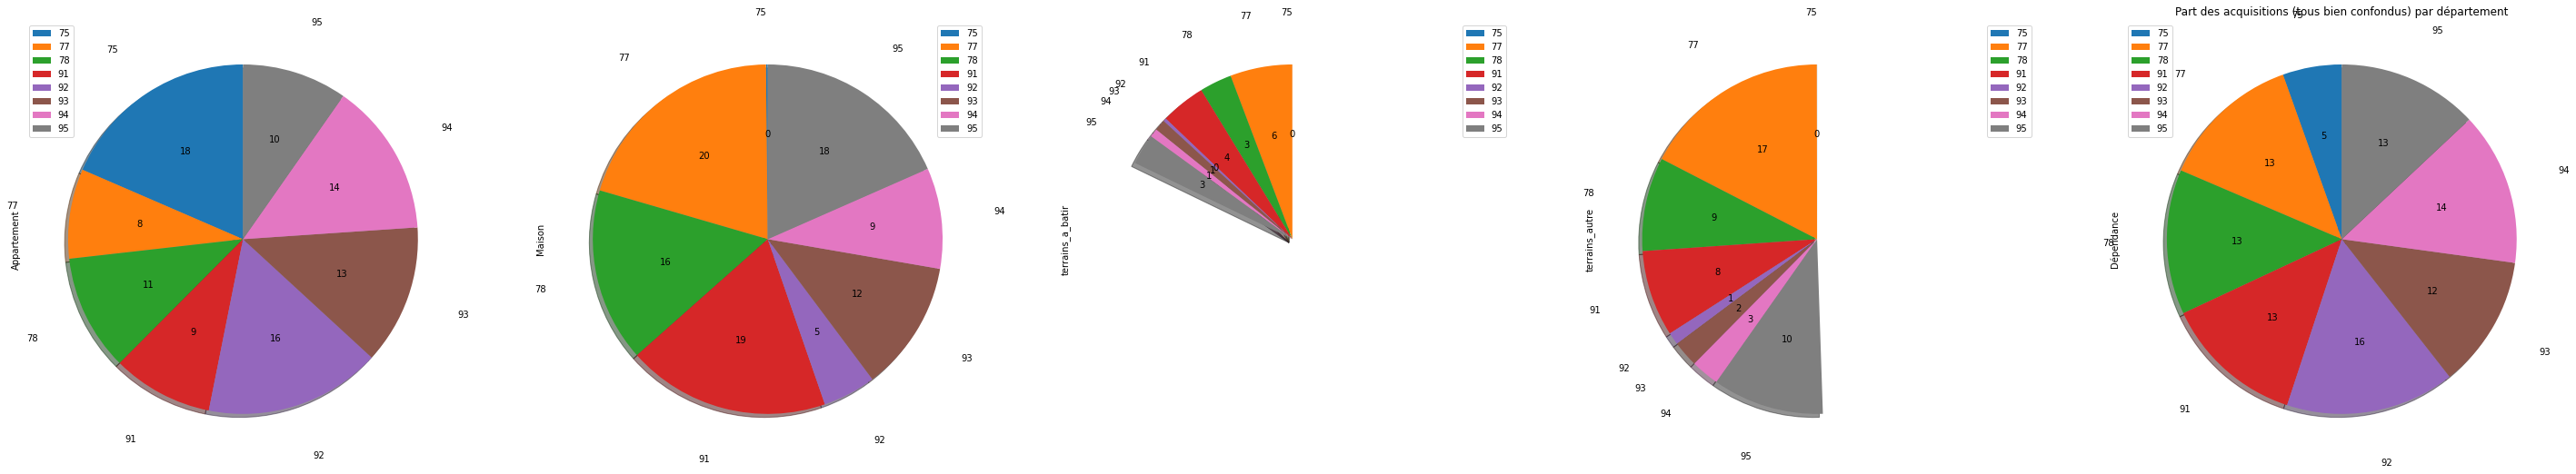

In [54]:
df1.groupby(['code_departement']).sum().plot(kind='pie', subplots=True, shadow = True,startangle=90,figsize=(50, 25), autopct='%.0f',labeldistance = 1.3)
plt.title('Part des acquisitions (tous bien confondus) par département');


Près de la moitié des appartements acquis en région IDF ont été achetés à Paris, en Seine Saint Denis et dans les Hauts de Seine. De même, 4 départements concentrent les achats de maisons : 77, 91, 95 et 78. Enfin un tiers des terrains à batir sont achetés en Seine et Marne.

# Analyse de la répartition des terrains (à batir et autres) selon les départements

In [55]:
df_terrain = df[['id_mutation', "surface_terrain","terrains_a_batir",'terrains_autre','code_departement']]
df_terrain.head()

,id_mutation,surface_terrain,terrains_a_batir,terrains_autre,code_departement
0,2019-1135463,855.0,0,1,77
1,2019-1135466,0.0,0,0,77
2,2019-1135467,12.0,0,0,77
3,2019-1135468,270.0,0,2,77
4,2019-1135469,1036.0,0,2,77


Il est d'abord nécessaire de supprimer les id_mutations pour lequels nous avons une valeur en surface de terrain mais qui n'appartient dont l'achat est un appartement ou une maison

In [56]:
toremove=df_terrain[(df_terrain["terrains_a_batir"]+df_terrain["terrains_autre"])==0]["id_mutation"].unique()
df_terrain_ok=df_terrain.loc[df_terrain["id_mutation"].isin(toremove)==False]

Voyons, à travers un boxplot, la répartition des surfaces achetées en mètre carrés

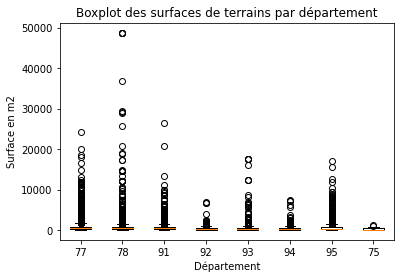

In [57]:
l=list()
for i in df_terrain_ok.code_departement.unique():
    l.append(df_terrain_ok[df_terrain_ok['code_departement'] == i]['surface_terrain'])
plt.boxplot(l)
plt.xticks(range(1,9),df_terrain_ok.code_departement.unique())

plt.title('Boxplot des surfaces de terrains par département')
plt.xlabel('Département')
plt.ylabel('Surface en m2')
plt.show();


Lorsqu'on regarde de plus près avec un histogramme, on voit qu'il reste peu d'id_mutation supérieures à 3000 m2

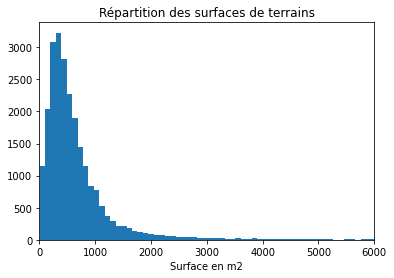

In [58]:
plt.hist([df_terrain_ok['surface_terrain']], bins = 500);
plt.xlim([0,6000])
plt.title('Répartition des surfaces de terrains')
plt.xlabel('Surface en m2');

# Boxplot de la surface des terrains (à batir et autres jusqu'à 3000 m2) selon les départements

Centrons maintenant les id_mutations comprises entre 0 et 3000 m2 de surface de terrains

In [59]:
remove=df_terrain_ok[(df_terrain_ok["surface_terrain"]>3000)]["id_mutation"].unique()
df_surface_ok=df_terrain_ok.loc[df_terrain_ok["id_mutation"].isin(remove)==False]

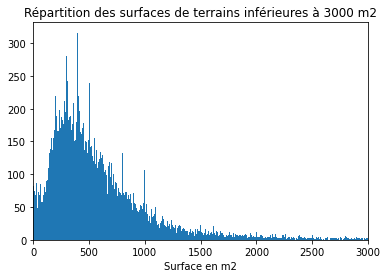

In [60]:
plt.hist([df_surface_ok['surface_terrain']], bins = 500)
plt.xlim([0,3000])
plt.title('Répartition des surfaces de terrains inférieures à 3000 m2')
plt.xlabel('Surface en m2');

Ce graph nous montre effectivement que l'essentiel des achats de terrains sont comrois entre 200 et 1000 m2

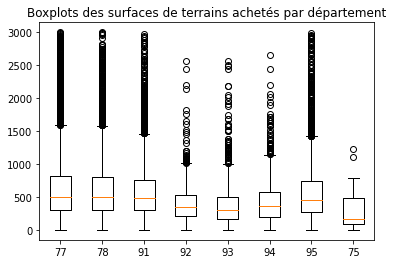

In [61]:
l=list()
for i in df_surface_ok.code_departement.unique():
    l.append(df_surface_ok[df_surface_ok['code_departement'] == i]['surface_terrain'])
plt.boxplot(l)
plt.xticks(range(1,9),df_surface_ok.code_departement.unique())
plt.title('Boxplots des surfaces de terrains achetés par département')
plt.show()

A nouveau, on remarque que Paris et sa petite couronne ont des boxplots qui se ressemblent avec une médiane à 300 m2 alors que la banlieue plus éloignée tend vers les 500 m2 avec davantage d'outliers

In [62]:
stats = pd.DataFrame(df_surface_ok.mean(), columns=['moyenne'])
stats['median'] = df_surface_ok.median()
stats

,moyenne,median
surface_terrain,590.232864,465.0
terrains_a_batir,0.313853,0.0
terrains_autre,0.871355,1.0
code_departement,inf,78.0


In [63]:
df_surface_ok.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23460 entries, 0 to 364123
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id_mutation       23460 non-null  object 
 1   surface_terrain   23460 non-null  float64
 2   terrains_a_batir  23460 non-null  int64  
 3   terrains_autre    23460 non-null  int64  
 4   code_departement  23460 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 1.1+ MB


In [64]:
fusion = df_surface_ok.merge(right = df, on = 'id_mutation', how = 'left')

In [65]:
pd.DataFrame(pearsonr(fusion['prix_m²'], fusion['valeur_fonciere']), index=['pearson_coeff','p-value'], columns=['resultat_du_test_de_pearson'])


,resultat_du_test_de_pearson
pearson_coeff,0.591825
p-value,0.000000


la P_value est inférieure à 5%, on rejette H0, les variables ne sont pas indépendantes. 
Les variables tendent à être décorrélées car le coefficient est proche de 0

In [66]:
pd.DataFrame(pearsonr(fusion['surface_terrain_y'], fusion['valeur_fonciere']), index=['pearson_coeff','p-value'], columns=['resultat_du_test_de_pearson'])


,resultat_du_test_de_pearson
pearson_coeff,1.842588e-01
p-value,3.194191e-178


A nouveau, la P_value est inférieure à 5%, on rejette H0, les variables ne sont pas indépendantes. 
Les variables tendent à être décorrélées car le coefficient est proche de 0

Au vue des données, on peut considérer comme outlyers les terrains dont la surface est supérieur à 3000m². Nous allons les retirer du dataframe.

In [67]:
df=df[df["surface_terrain"]<3000]

# Export du dataframe en csv

Notre dataframe est maintenant nettoyé de ses outlyers. Nous allons l'exporter en csv. Celui ci servira de base pour le futur modèle de régression.

In [68]:
df.to_csv("IDF_2019_to_2021_v3.csv", index=False)